<a href="https://colab.research.google.com/github/kibuba-njihia/mastering-tensorflow/blob/main/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c03_moving_average.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Moving average

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c03_moving_average.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c03_moving_average.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

## Trend and Seasonality

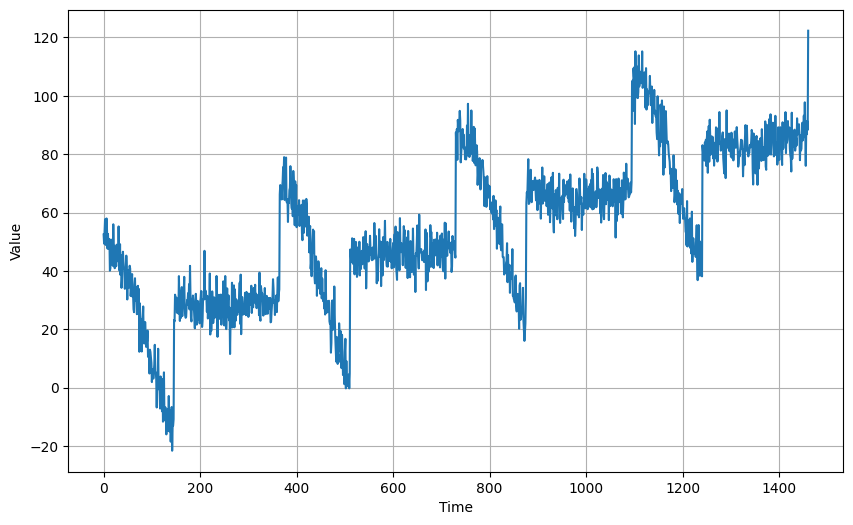

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Naive Forecast

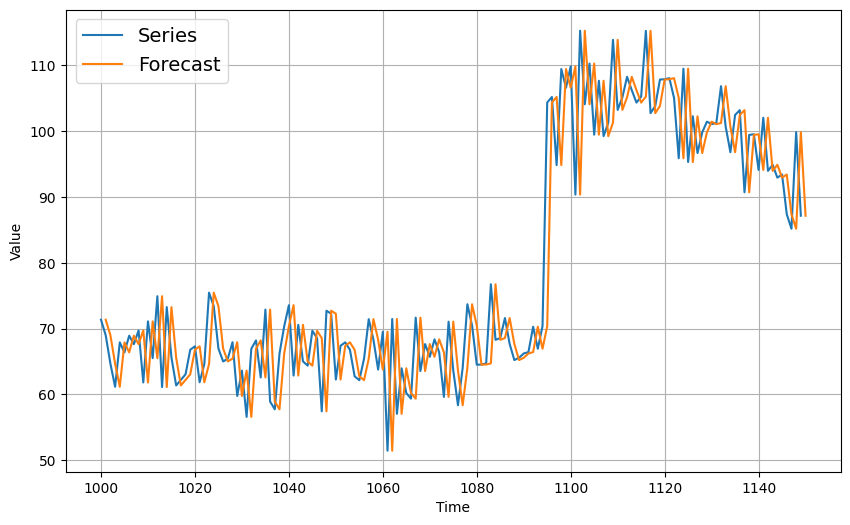

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

Now let's compute the mean absolute error between the forecasts and the predictions in the validation period:

In [8]:
!pip install tensorflow --upgrade

In [10]:
keras.metrics.mse(x_valid, naive_forecast).numpy()
# keras.metrics.MeanAbsoluteError(x_valid, naive_forecast).numpy()

61.82753366856369

That's our baseline, now let's try a moving average.

## Moving Average

In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

In [ ]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [ ]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

In [ ]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

Focusing on the validation period:

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

In [ ]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

In [ ]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [ ]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

In [ ]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [ ]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

That's starting to look pretty good! Let's see if we can do better with a Machine Learning model.